# Wk18 Lecture02 CodeAlong: UFOs

## Learning Objectives

- By the end of this CodeAlong, students will be able to:
   - Calculate time series statistics (rolling mean/std/diff/pct_change

    

# 🕹️Part 1) Preparing Irregular-Interval Time Series

### Overview from Last Lecture

- 1) [ ] Convert the dates & times to a single column (if needed).
- 2) [ ] Convert the datetime column  (most likely a string) to a datetime data type.
- 3) [ ] Set the datetime column as the Series/DataFrame index
- 4) [ ] Resample the time series to the desired/correct frequency using the desired/correct aggregation method.
- 5) [ ] Impute null values (if required)


### UFO Sightings

- UFO Sightings: https://www.kaggle.com/datasets/NUFORC/ufo-sightings 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticks
import seaborn as sns


import missingno as miss
import datetime as dt
import statsmodels.tsa.api as tsa

In [2]:
df  = pd.read_csv("Data/ufos-kaggle/scrubbed.csv", low_memory=False)
df

datetime                  city state country     shape  \
0      10/10/1949 20:30            san marcos    tx      us  cylinder   
1      10/10/1949 21:00          lackland afb    tx     NaN     light   
2      10/10/1955 17:00  chester (uk/england)   NaN      gb    circle   
3      10/10/1956 21:00                  edna    tx      us    circle   
4      10/10/1960 20:00               kaneohe    hi      us     light   
...                 ...                   ...   ...     ...       ...   
80327    9/9/2013 21:15             nashville    tn      us     light   
80328    9/9/2013 22:00                 boise    id      us    circle   
80329    9/9/2013 22:00                  napa    ca      us     other   
80330    9/9/2013 22:20                vienna    va      us    circle   
80331    9/9/2013 23:00                edmond    ok      us     cigar   

      duration (seconds) duration (hours/min)  \
0                   2700           45 minutes   
1                   7200              1-2 hrs   
2                     20           20 seconds   
3                     20             1/2 hour   
4                    900           15 minutes   
...                  ...                  ...   
80327                600           10 minutes   
80328               1200           20 minutes   
80329               1200                 hour   
80330                  5            5 seconds   
80331               1020           17 minutes   

                                                comments date posted  \
0      This event took place in early fall around 194...   4/27/2004   
1      1949 Lackland AFB&#44 TX.  Lights racing acros...  12/16/2005   
2      Green/Orange circular disc over Chester&#44 En...   1/21/2008   
3      My older brother and twin sister were leaving ...   1/17/2004   
4      AS a Marine 1st Lt. flying an FJ4B fighter/att...   1/22/2004   
...                                                  ...         ...   
80327  Round from the distance/slowly changing colors...   9/30/2013   
80328  Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...   9/30/2013   
80329                                       Napa UFO&#44   9/30/2013   
80330  Saw a five gold lit cicular craft moving fastl...   9/30/2013   
80331  2 witnesses 2  miles apart&#44 Red &amp; White...   9/30/2013   

         latitude  longitude   
0      29.8830556  -97.941111  
1        29.38421  -98.581082  
2            53.2   -2.916667  
3      28.9783333  -96.645833  
4      21.4180556 -157.803611  
...           ...         ...  
80327  36.1658333  -86.784444  
80328  43.6136111 -116.202500  
80329  38.2972222 -122.284444  
80330  38.9011111  -77.265556  
80331  35.6527778  -97.477778  

[80332 rows x 11 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   datetime              80332 non-null  object 
 1   city                  80332 non-null  object 
 2   state                 74535 non-null  object 
 3   country               70662 non-null  object 
 4   shape                 78400 non-null  object 
 5   duration (seconds)    80332 non-null  object 
 6   duration (hours/min)  80332 non-null  object 
 7   comments              80317 non-null  object 
 8   date posted           80332 non-null  object 
 9   latitude              80332 non-null  object 
 10  longitude             80332 non-null  float64
dtypes: float64(1), object(10)
memory usage: 6.7+ MB


>- 1) [x] Convert the dates & times to a single column (if needed).

## Preparing the Datetime Index

## 1. All Dates and Times in One Row:

This is already true here; nothing to change.

## 2. Converting Date Cols to Datetime

In [4]:
## Investigate the date format
df.loc[0,'datetime']

'10/10/1949 20:30'

In [5]:
## Set the date format
fmt = '%m/%d/%Y %H:%M'

In [6]:
## convert datetime to datetime
df['datetime'] = pd.to_datetime(df['datetime'], format=fmt)

ValueError: time data '10/11/2006 24:00' does not match format '%m/%d/%Y %H:%M' (match)

### Handling Errors with pd.to_datetime

- Can use the `errors` argument for pd.to_datetime:
    - "raise" (default): raise an exception when errors happen
    - 'ignore': ignores the errors and returns the original value for that row. 
        - NOT RECOMMENDED: the entire column will not be datetime.
    - 'coerce': convert any bad datetime values to null values (NaT - NotATime)

>- **Branch point: we have a choice on how we deal with the bad timestamps.**
    -  Do we coerce them, make then null values, and drop them? Potentially losing a lot of data.
    - Or do we investigate a bit more to see if we can fix the problem without losing data.
    
    
- Let's see how much data we would lose if we chose to coerce the bad values:

In [7]:
##check nulls before coercing errors
df.isna().sum()

datetime                   0
city                       0
state                   5797
country                 9670
shape                   1932
duration (seconds)         0
duration (hours/min)       0
comments                  15
date posted                0
latitude                   0
longitude                  0
dtype: int64

In [8]:
## Check missing data after coerce
coerced_dt = pd.to_datetime(df["datetime"], format=fmt, errors='coerce')
coerced_dt.isna().sum() / len(df)

0.008639147537718469

Should we drop the rows, or try to fix the times?

In [9]:
## Drop the rows
# df = df.dropna(subset = 'datetime')

In [10]:
## Fix the errors: 
df['datetime'] = df['datetime'].str.replace('24:00', '23:59')
df['datetime'] = pd.to_datetime(df['datetime'], format = fmt)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80332 entries, 0 to 80331
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   datetime              80332 non-null  datetime64[ns]
 1   city                  80332 non-null  object        
 2   state                 74535 non-null  object        
 3   country               70662 non-null  object        
 4   shape                 78400 non-null  object        
 5   duration (seconds)    80332 non-null  object        
 6   duration (hours/min)  80332 non-null  object        
 7   comments              80317 non-null  object        
 8   date posted           80332 non-null  object        
 9   latitude              80332 non-null  object        
 10  longitude             80332 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(9)
memory usage: 6.7+ MB


## 3. Setting datetime index

In [11]:
ufo_ts = df.set_index('datetime')
ufo_ts

city state country     shape  \
datetime                                                            
1949-10-10 20:30:00            san marcos    tx      us  cylinder   
1949-10-10 21:00:00          lackland afb    tx     NaN     light   
1955-10-10 17:00:00  chester (uk/england)   NaN      gb    circle   
1956-10-10 21:00:00                  edna    tx      us    circle   
1960-10-10 20:00:00               kaneohe    hi      us     light   
...                                   ...   ...     ...       ...   
2013-09-09 21:15:00             nashville    tn      us     light   
2013-09-09 22:00:00                 boise    id      us    circle   
2013-09-09 22:00:00                  napa    ca      us     other   
2013-09-09 22:20:00                vienna    va      us    circle   
2013-09-09 23:00:00                edmond    ok      us     cigar   

                    duration (seconds) duration (hours/min)  \
datetime                                                      
1949-10-10 20:30:00               2700           45 minutes   
1949-10-10 21:00:00               7200              1-2 hrs   
1955-10-10 17:00:00                 20           20 seconds   
1956-10-10 21:00:00                 20             1/2 hour   
1960-10-10 20:00:00                900           15 minutes   
...                                ...                  ...   
2013-09-09 21:15:00                600           10 minutes   
2013-09-09 22:00:00               1200           20 minutes   
2013-09-09 22:00:00               1200                 hour   
2013-09-09 22:20:00                  5            5 seconds   
2013-09-09 23:00:00               1020           17 minutes   

                                                              comments  \
datetime                                                                 
1949-10-10 20:30:00  This event took place in early fall around 194...   
1949-10-10 21:00:00  1949 Lackland AFB&#44 TX.  Lights racing acros...   
1955-10-10 17:00:00  Green/Orange circular disc over Chester&#44 En...   
1956-10-10 21:00:00  My older brother and twin sister were leaving ...   
1960-10-10 20:00:00  AS a Marine 1st Lt. flying an FJ4B fighter/att...   
...                                                                ...   
2013-09-09 21:15:00  Round from the distance/slowly changing colors...   
2013-09-09 22:00:00  Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...   
2013-09-09 22:00:00                                       Napa UFO&#44   
2013-09-09 22:20:00  Saw a five gold lit cicular craft moving fastl...   
2013-09-09 23:00:00  2 witnesses 2  miles apart&#44 Red &amp; White...   

                    date posted    latitude  longitude   
datetime                                                 
1949-10-10 20:30:00   4/27/2004  29.8830556  -97.941111  
1949-10-10 21:00:00  12/16/2005    29.38421  -98.581082  
1955-10-10 17:00:00   1/21/2008        53.2   -2.916667  
1956-10-10 21:00:00   1/17/2004  28.9783333  -96.645833  
1960-10-10 20:00:00   1/22/2004  21.4180556 -157.803611  
...                         ...         ...         ...  
2013-09-09 21:15:00   9/30/2013  36.1658333  -86.784444  
2013-09-09 22:00:00   9/30/2013  43.6136111 -116.202500  
2013-09-09 22:00:00   9/30/2013  38.2972222 -122.284444  
2013-09-09 22:20:00   9/30/2013  38.9011111  -77.265556  
2013-09-09 23:00:00   9/30/2013  35.6527778  -97.477778  

[80332 rows x 10 columns]

In [12]:
# check the index to confirm its datetime
ufo_ts.index

DatetimeIndex(['1949-10-10 20:30:00', '1949-10-10 21:00:00',
               '1955-10-10 17:00:00', '1956-10-10 21:00:00',
               '1960-10-10 20:00:00', '1961-10-10 19:00:00',
               '1965-10-10 21:00:00', '1965-10-10 23:45:00',
               '1966-10-10 20:00:00', '1966-10-10 21:00:00',
               ...
               '2013-09-09 21:00:00', '2013-09-09 21:00:00',
               '2013-09-09 21:00:00', '2013-09-09 21:00:00',
               '2013-09-09 21:00:00', '2013-09-09 21:15:00',
               '2013-09-09 22:00:00', '2013-09-09 22:00:00',
               '2013-09-09 22:20:00', '2013-09-09 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=80332, freq=None)

- 3) [x] Set the datetime column as the Series/DataFrame index

## 4. Resampling

What frequency should we use?

### Let's Visualize Our Data

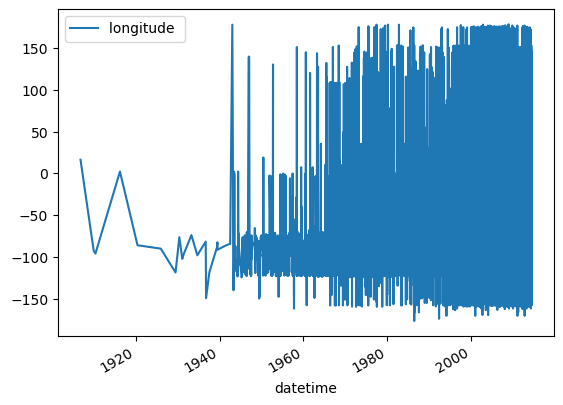

In [13]:
ufo_ts.plot();

> Hmmmm.... what are we *trying* to visualize?



### What do we really want to know about UFO's? 
- Duration of sighting?
- Location of sighting?
- Number of sightings?

## Timeseries of Number of Sightings

- We want to quantify the number of events that occurred within each interval.
- What aggregratagor should we use?


In [14]:
## Resample as daily
ts =  ufo_ts.resample('D').size()
ts.head()

datetime
1906-11-11    1
1906-11-12    0
1906-11-13    0
1906-11-14    0
1906-11-15    0
Freq: D, dtype: int64

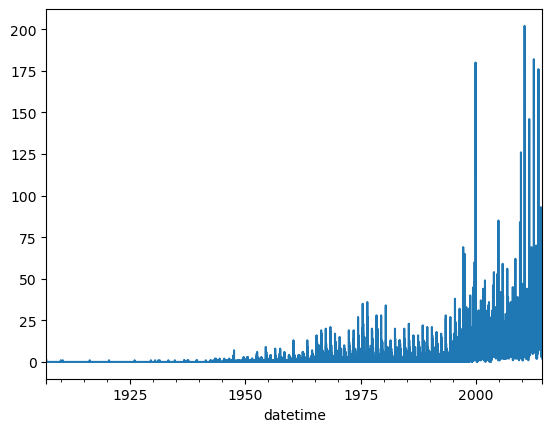

In [15]:
ts.plot();

In [16]:
## Change figsize
plt.rcParams['figure.figsize'] = [10,5]

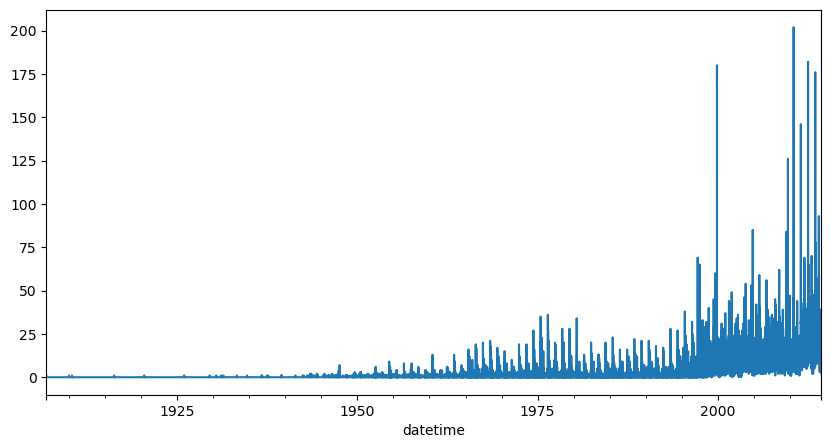

In [17]:
## Plot again
ts.plot();

Not much was happening before 1950.


Let's keep data from 1950 to present day

In [18]:
ts = ts.loc["1950":]
ts

datetime
1950-01-01     0
1950-01-02     1
1950-01-03     0
1950-01-04     0
1950-01-05     0
              ..
2014-05-04     8
2014-05-05    13
2014-05-06    12
2014-05-07    13
2014-05-08     2
Freq: D, Length: 23504, dtype: int64

# 🕹️Part 2) Time Series Analysis: Statistics

## 📝 **Stakeholder Questions to Answer**

**ANSWER TOGETHER:**
1) How are UFO sightings trending since 1950?


2) How Has the Total Number of UFO's Sighted Changed Over the Years?


3) How Has the Variance of UFO Sightings Changed Over the Years?


4) Is there a cycle (seasonality) to UFO sightings?  How long is the season?


5) How are different shapes of UFOs trending?

# Stakeholder Question 1: How are UFO sightings trending since 1950?

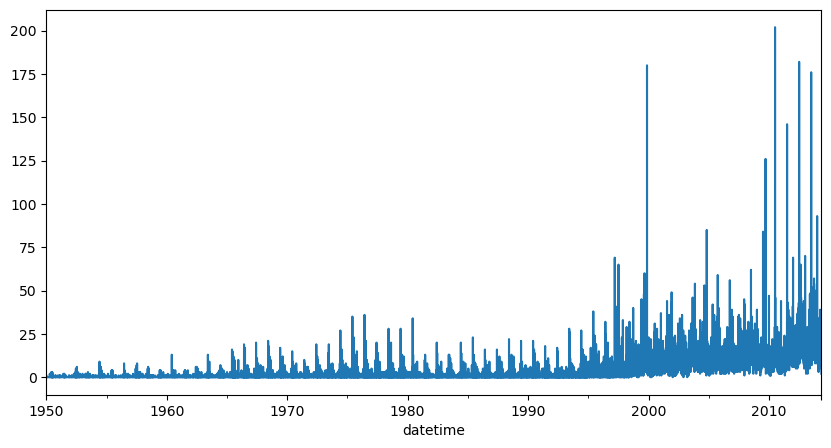

In [19]:
## Plot the time series
ts.plot();

The plot is very noisy with some days having a large number of sightings.  Let's see if we can smooth it out some to better identify trends.  

We will take a 30 day rolling mean.

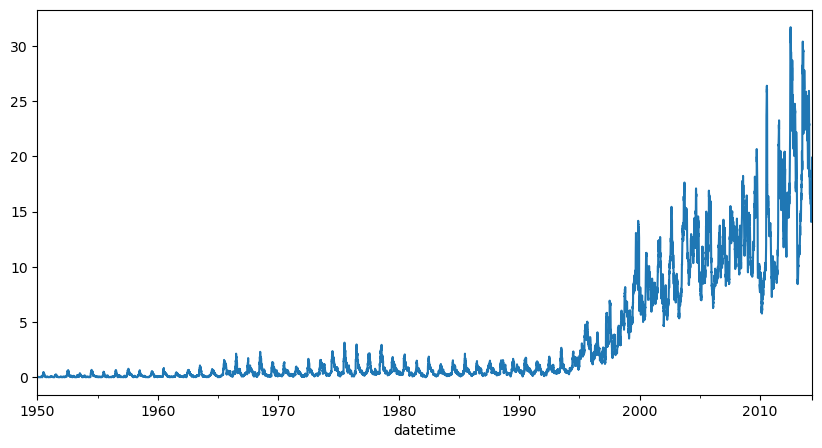

In [20]:
## Try a rolling mean to smooth the noise
rolling_30 = ts.rolling(30).mean()
rolling_30.plot();

## 30 Day Rolling Mean vs Monthly Frequency:

* 30 day rolling mean is still daily frequency, but each value is the average of the previous 30 days

* Monthly frequency shows the average of EACH month (Feb. 2000, March 2000, etc.)

# Stakeholder Question 2: How Has the Total Number of UFO's Sighted Changed Over the Years?

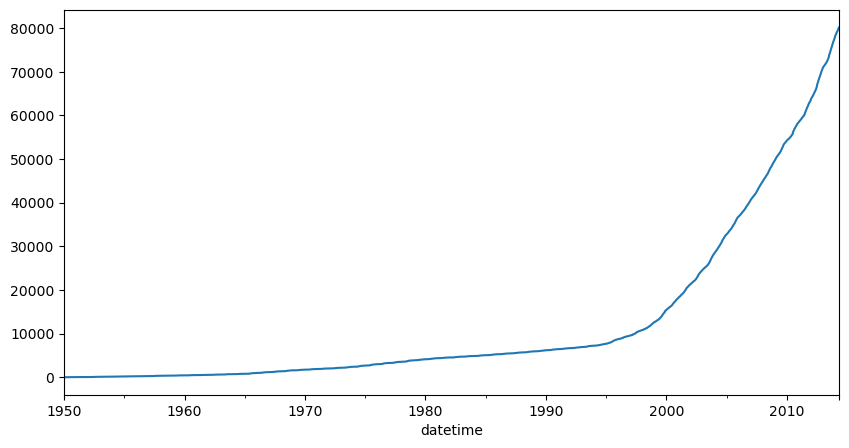

In [21]:
## Plot a cumulative sum of sightings
ts.cumsum().plot();

# Stakeholder Question 3: How Has the Variance of UFO Sightings Changed Over the Years?

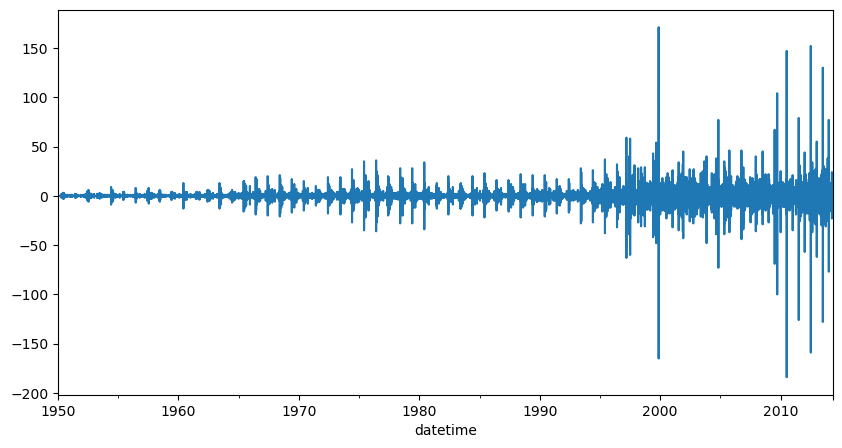

In [22]:
## Plot the difference to find the change in variance.  Would smoothing help?
ts.diff().plot();

## Question 3b:  Can we normalize that to a percentage?

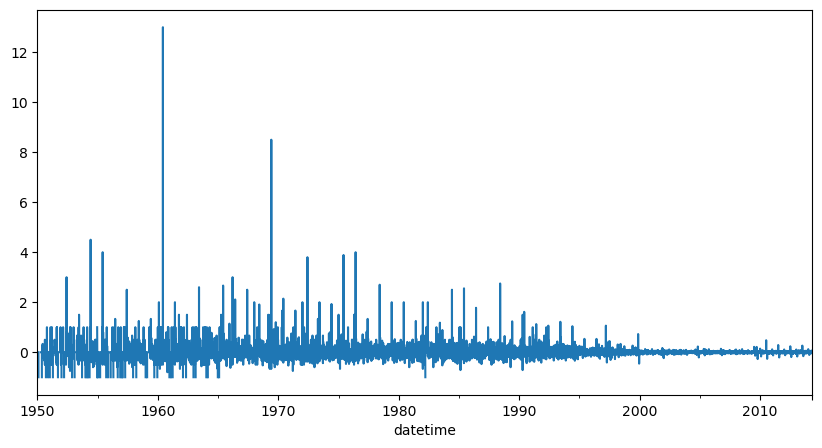

In [23]:
## Plot percentage change instead of just raw difference
rolling_30.pct_change().plot();

### Reflection Question: Why are these plots so different?

# Stakeholder question 4: Is there a cycle (seasonality) to UFO sightings?

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

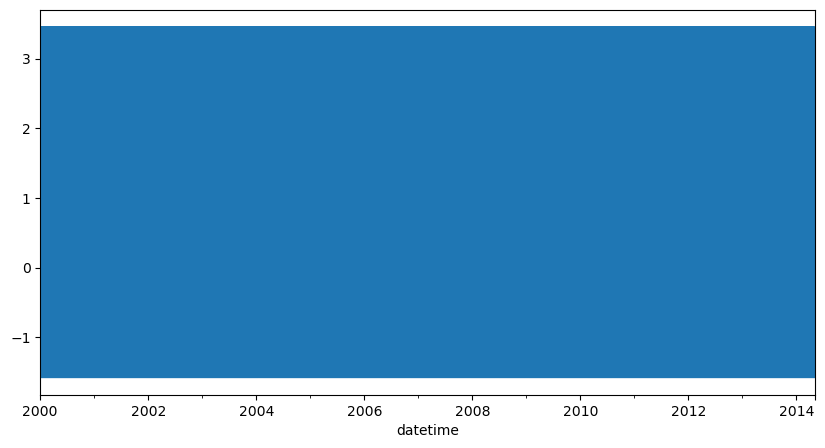

In [25]:
## Try seasonal decompose on the time series to find seasonality
results = seasonal_decompose(ts.loc['2000':])
results.seasonal.plot();

## Exploring Seasonality

The above plot is not very informative.  The seasons are probably too close together to differentiate.  

We could try:

1. Zooming in to a single year or month
2. Downsampling our data to weeks, months, or years

## Zooming In:

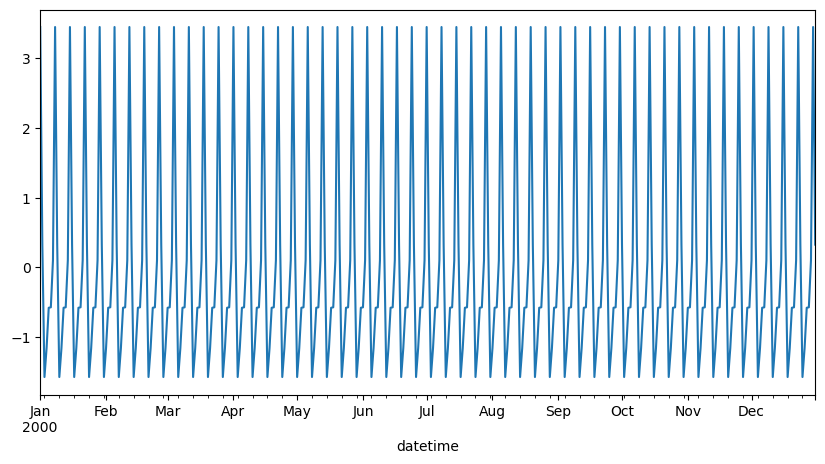

In [26]:
## Zoom in to 1 year
results.seasonal.loc['2000'].plot();

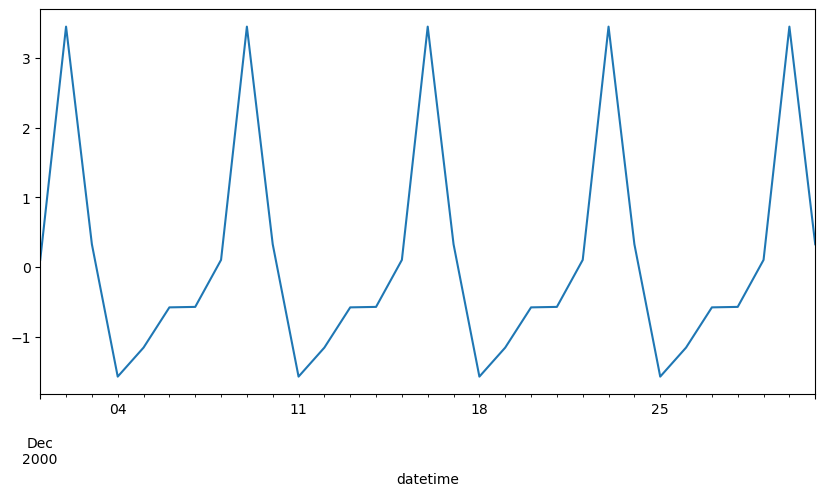

In [27]:
## Zoom in to one month
results.seasonal.loc['12/2000'].plot();

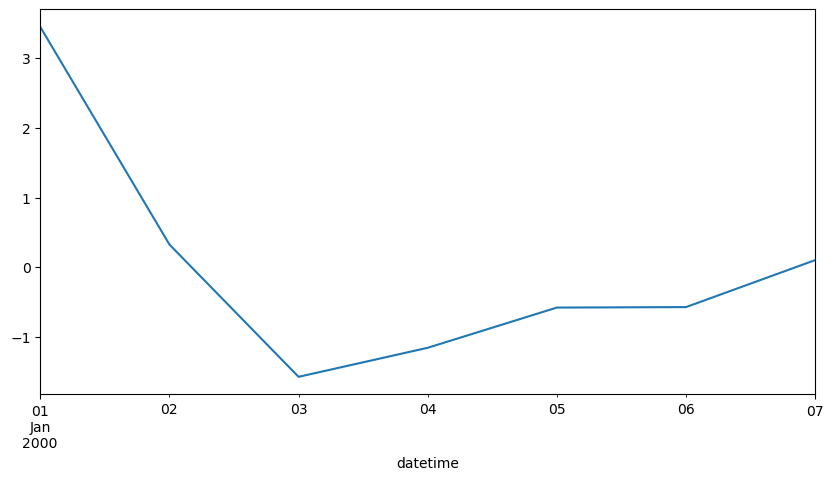

In [28]:
## Check the days of the week
results.seasonal.loc['1/1/2000':'1/7/2000'].plot();

In [29]:
days = results.seasonal.loc['1/2000'].index.day_name()
days

Index(['Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday',
       'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday',
       'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
       'Monday'],
      dtype='object', name='datetime')

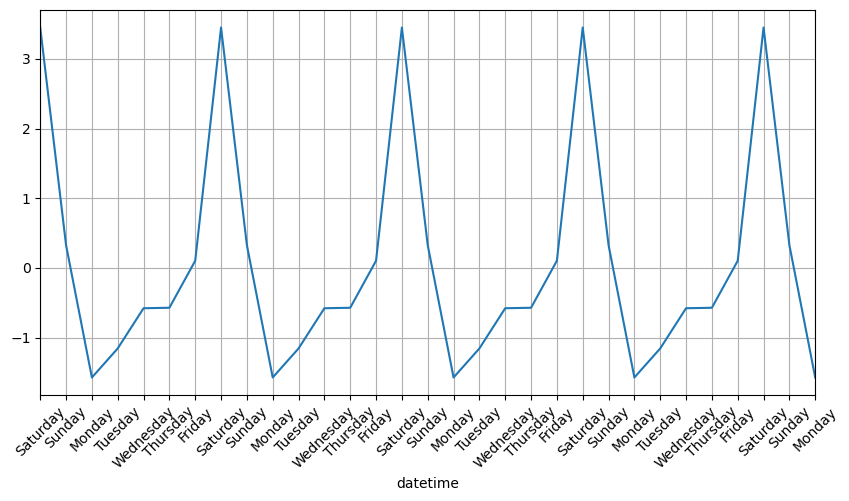

In [30]:
## Plot the seasonal series again with day names as the xticks
results.seasonal.loc['1/2000'].plot();

# Change the xtick labels to the days of the week, rotate them 90 degrees
plt.xticks(ticks = results.seasonal.loc['1/2000'].index, labels = days, rotation = 45)
plt.grid();

### What is the magnitude of difference at weekly seasonality?

## Downsampling (Monthly)

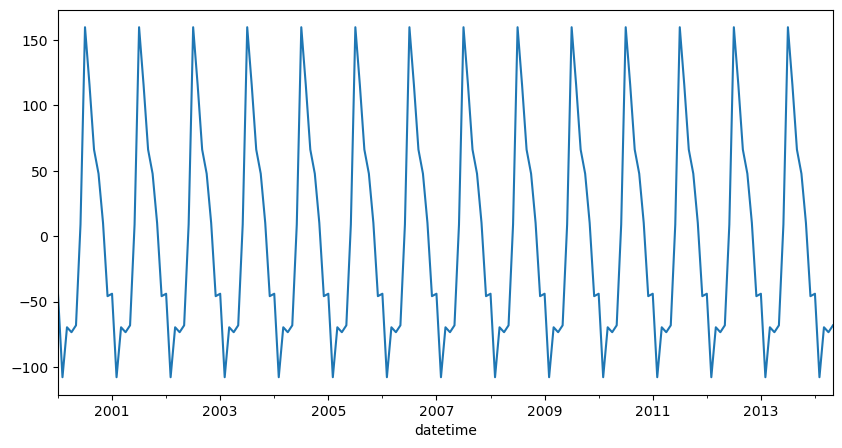

In [31]:
## Resample as monthly
m_ts = ts.resample('M').sum()

## Decompose
results = seasonal_decompose(m_ts.loc['2000':])

## Plot seasonal element
results.seasonal.plot();

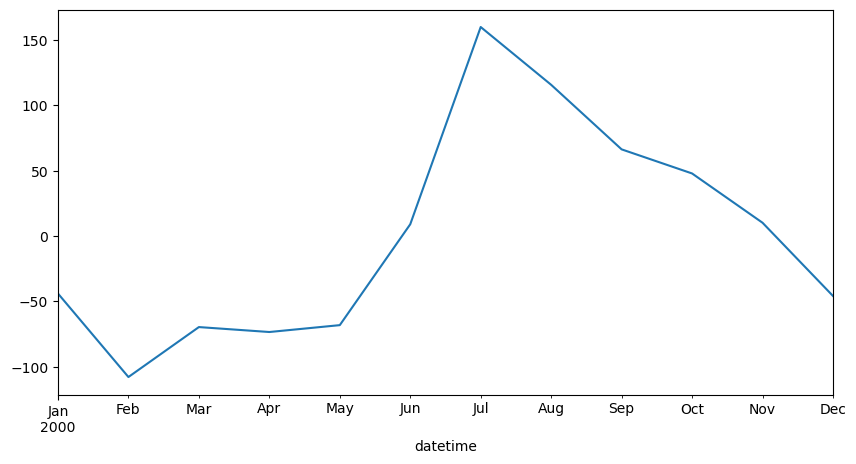

In [32]:
## Zoom in to one year
results.seasonal.loc['2000'].plot();

### What is the magnitude of difference at yearly seasonality?

# Stakeholder Question 5: How are different shapes of UFOs trending?

In [33]:
## Recheck the ufo_ts dataframe so we can pull out the shapes
ufo_ts.head()

city state country     shape  \
datetime                                                            
1949-10-10 20:30:00            san marcos    tx      us  cylinder   
1949-10-10 21:00:00          lackland afb    tx     NaN     light   
1955-10-10 17:00:00  chester (uk/england)   NaN      gb    circle   
1956-10-10 21:00:00                  edna    tx      us    circle   
1960-10-10 20:00:00               kaneohe    hi      us     light   

                    duration (seconds) duration (hours/min)  \
datetime                                                      
1949-10-10 20:30:00               2700           45 minutes   
1949-10-10 21:00:00               7200              1-2 hrs   
1955-10-10 17:00:00                 20           20 seconds   
1956-10-10 21:00:00                 20             1/2 hour   
1960-10-10 20:00:00                900           15 minutes   

                                                              comments  \
datetime                                                                 
1949-10-10 20:30:00  This event took place in early fall around 194...   
1949-10-10 21:00:00  1949 Lackland AFB&#44 TX.  Lights racing acros...   
1955-10-10 17:00:00  Green/Orange circular disc over Chester&#44 En...   
1956-10-10 21:00:00  My older brother and twin sister were leaving ...   
1960-10-10 20:00:00  AS a Marine 1st Lt. flying an FJ4B fighter/att...   

                    date posted    latitude  longitude   
datetime                                                 
1949-10-10 20:30:00   4/27/2004  29.8830556  -97.941111  
1949-10-10 21:00:00  12/16/2005    29.38421  -98.581082  
1955-10-10 17:00:00   1/21/2008        53.2   -2.916667  
1956-10-10 21:00:00   1/17/2004  28.9783333  -96.645833  
1960-10-10 20:00:00   1/22/2004  21.4180556 -157.803611

In [34]:
## Group by shape, resample to monthly, and aggregate by size
shapes = ufo_ts.groupby('shape').resample('M').size()
shapes

shape     datetime  
changed   1996-06-30     1
changing  1954-07-31     1
          1954-08-31     0
          1954-09-30     0
          1954-10-31     0
                        ..
unknown   2014-01-31    39
          2014-02-28    37
          2014-03-31    40
          2014-04-30    38
          2014-05-31     8
Length: 19344, dtype: int64

In [35]:
## Unstack the shapes
shape_unstacked = shapes.unstack(level = 0)
shape_unstacked.head()

shape       changed  changing  chevron  cigar  circle  cone  crescent  cross  \
datetime                                                                       
1906-11-30      NaN       NaN      NaN    NaN     NaN   NaN       NaN    NaN   
1906-12-31      NaN       NaN      NaN    NaN     NaN   NaN       NaN    NaN   
1907-01-31      NaN       NaN      NaN    NaN     NaN   NaN       NaN    NaN   
1907-02-28      NaN       NaN      NaN    NaN     NaN   NaN       NaN    NaN   
1907-03-31      NaN       NaN      NaN    NaN     NaN   NaN       NaN    NaN   

shape       cylinder  delta  ...  light  other  oval  pyramid  rectangle  \
datetime                     ...                                           
1906-11-30       NaN    NaN  ...    NaN    1.0   NaN      NaN        NaN   
1906-12-31       NaN    NaN  ...    NaN    0.0   NaN      NaN        NaN   
1907-01-31       NaN    NaN  ...    NaN    0.0   NaN      NaN        NaN   
1907-02-28       NaN    NaN  ...    NaN    0.0   NaN      NaN        NaN   
1907-03-31       NaN    NaN  ...    NaN    0.0   NaN      NaN        NaN   

shape       round  sphere  teardrop  triangle  unknown  
datetime                                                
1906-11-30    NaN     NaN       NaN       NaN      NaN  
1906-12-31    NaN     NaN       NaN       NaN      NaN  
1907-01-31    NaN     NaN       NaN       NaN      NaN  
1907-02-28    NaN     NaN       NaN       NaN      NaN  
1907-03-31    NaN     NaN       NaN       NaN      NaN  

[5 rows x 29 columns]

In [36]:
## slice out just data from after 1950
shape_unstacked = shape_unstacked.loc['1950':]

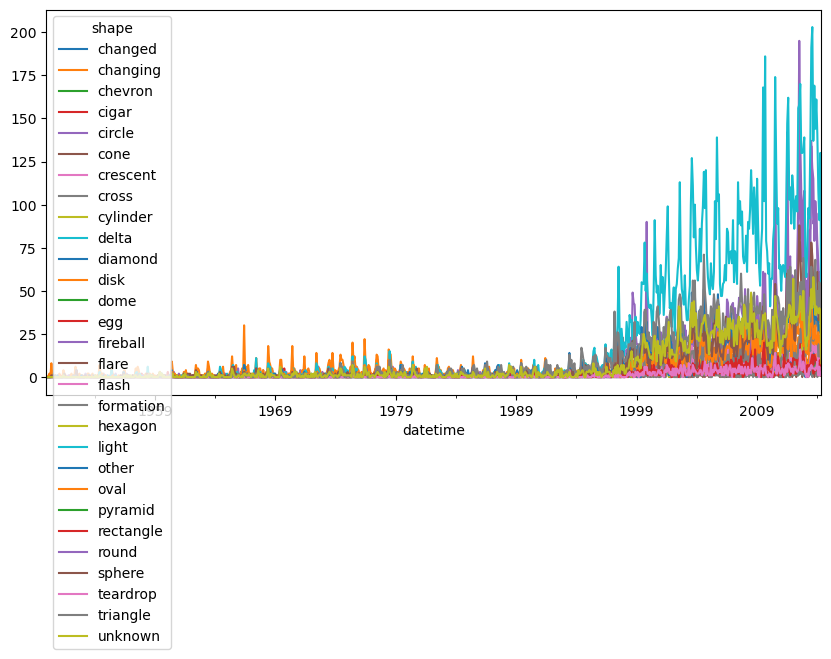

In [37]:
## Plot the shape time series
shape_unstacked.plot();

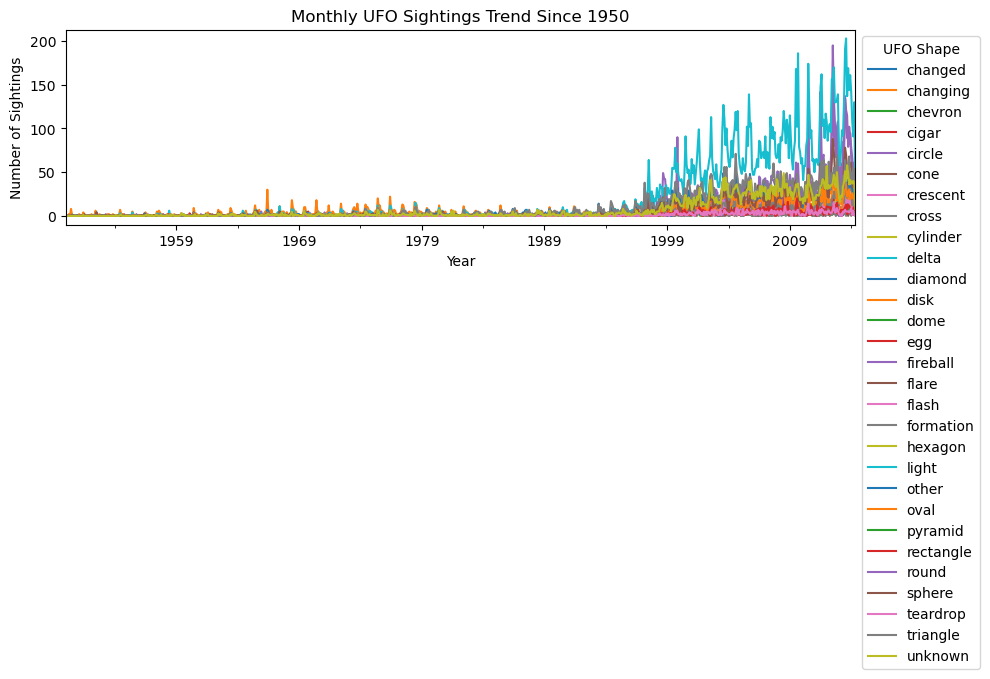

In [38]:
shape_unstacked.plot()
plt.title('Monthly UFO Sightings Trend Since 1950')
plt.xlabel('Year')
plt.ylabel('Number of Sightings')
plt.legend(title = 'UFO Shape', bbox_to_anchor = (1, 1), loc = 'upper left')
plt.tight_layout()
plt.show();

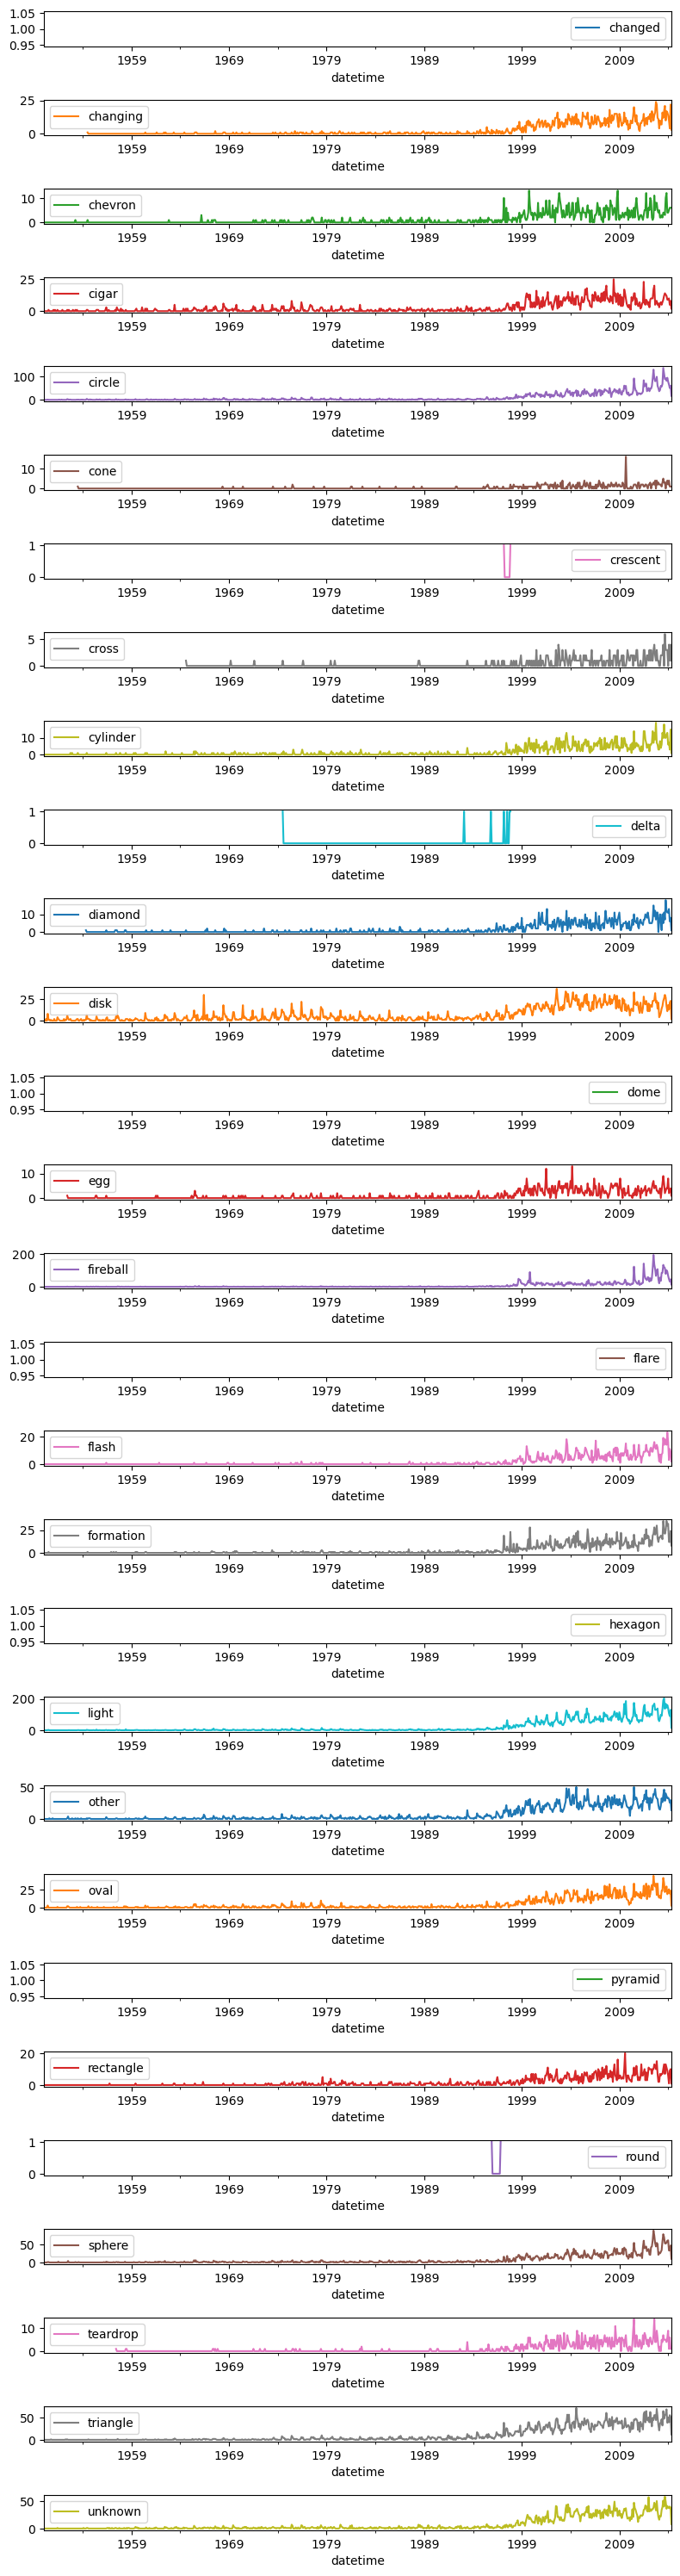

In [39]:
## Plot again, but with subplots = True
## Set sharey and sharex to False, choose a layout and try figure size (8,30)
shape_unstacked.plot(figsize = (8, 30),
                      subplots = True,
                      sharey = False,
                      sharex = False,
                      layout = (-1, 1))

## Set the figure to a tight layout to prevent overlapping labels
plt.tight_layout();

## 🏓**Breakout Rooms: Answering Stakeholder Questions**

**Choose 1-2 of the remaining questions and work in breakout rooms to answer them:**
- 6) What holiday has the most UFO sightings?
- 7) What day of the week has the highest reported sightings?
- 8) At what time of day (hour) do most sightings occur?
- 9) Which US state has the most sightings?
- 10) Which country had the largest proportion of sightings for the year 2000?


In [40]:
## Make a copy of ufo_ts to play around with
eda_df = ufo_ts.copy()

### 5) Which US holiday has the largest number of sightings?

#### Feature Engineering: Holidays

In [41]:
# !pip install holidays
import holidays
import datetime as dt
from holidays import country_holidays

In [42]:
## Create an instance of the US country holidays.
us_holidays = country_holidays('US')
us_holidays

holidays.country_holidays('US')

In [43]:
## create a test holiday 
test = '01/01/2015'
test

'01/01/2015'

In [44]:
## test the api 
us_holidays.get(test)

"New Year's Day"

In [45]:
## Saving both holidays as a column
eda_df['US Holiday'] = eda_df.index.map(us_holidays.get)
eda_df

city state country     shape  \
datetime                                                            
1949-10-10 20:30:00            san marcos    tx      us  cylinder   
1949-10-10 21:00:00          lackland afb    tx     NaN     light   
1955-10-10 17:00:00  chester (uk/england)   NaN      gb    circle   
1956-10-10 21:00:00                  edna    tx      us    circle   
1960-10-10 20:00:00               kaneohe    hi      us     light   
...                                   ...   ...     ...       ...   
2013-09-09 21:15:00             nashville    tn      us     light   
2013-09-09 22:00:00                 boise    id      us    circle   
2013-09-09 22:00:00                  napa    ca      us     other   
2013-09-09 22:20:00                vienna    va      us    circle   
2013-09-09 23:00:00                edmond    ok      us     cigar   

                    duration (seconds) duration (hours/min)  \
datetime                                                      
1949-10-10 20:30:00               2700           45 minutes   
1949-10-10 21:00:00               7200              1-2 hrs   
1955-10-10 17:00:00                 20           20 seconds   
1956-10-10 21:00:00                 20             1/2 hour   
1960-10-10 20:00:00                900           15 minutes   
...                                ...                  ...   
2013-09-09 21:15:00                600           10 minutes   
2013-09-09 22:00:00               1200           20 minutes   
2013-09-09 22:00:00               1200                 hour   
2013-09-09 22:20:00                  5            5 seconds   
2013-09-09 23:00:00               1020           17 minutes   

                                                              comments  \
datetime                                                                 
1949-10-10 20:30:00  This event took place in early fall around 194...   
1949-10-10 21:00:00  1949 Lackland AFB&#44 TX.  Lights racing acros...   
1955-10-10 17:00:00  Green/Orange circular disc over Chester&#44 En...   
1956-10-10 21:00:00  My older brother and twin sister were leaving ...   
1960-10-10 20:00:00  AS a Marine 1st Lt. flying an FJ4B fighter/att...   
...                                                                ...   
2013-09-09 21:15:00  Round from the distance/slowly changing colors...   
2013-09-09 22:00:00  Boise&#44 ID&#44 spherical&#44 20 min&#44 10 r...   
2013-09-09 22:00:00                                       Napa UFO&#44   
2013-09-09 22:20:00  Saw a five gold lit cicular craft moving fastl...   
2013-09-09 23:00:00  2 witnesses 2  miles apart&#44 Red &amp; White...   

                    date posted    latitude  longitude  US Holiday  
datetime                                                            
1949-10-10 20:30:00   4/27/2004  29.8830556  -97.941111       None  
1949-10-10 21:00:00  12/16/2005    29.38421  -98.581082       None  
1955-10-10 17:00:00   1/21/2008        53.2   -2.916667       None  
1956-10-10 21:00:00   1/17/2004  28.9783333  -96.645833       None  
1960-10-10 20:00:00   1/22/2004  21.4180556 -157.803611       None  
...                         ...         ...         ...        ...  
2013-09-09 21:15:00   9/30/2013  36.1658333  -86.784444       None  
2013-09-09 22:00:00   9/30/2013  43.6136111 -116.202500       None  
2013-09-09 22:00:00   9/30/2013  38.2972222 -122.284444       None  
2013-09-09 22:20:00   9/30/2013  38.9011111  -77.265556       None  
2013-09-09 23:00:00   9/30/2013  35.6527778  -97.477778       None  

[80332 rows x 11 columns]

In [46]:
## Show unique holidays in the dataset
eda_df['US Holiday'].unique()

array([None, 'Columbus Day', 'Veterans Day', 'Veterans Day (Observed)',
       "New Year's Day", 'Thanksgiving', 'Martin Luther King Jr. Day',
       "New Year's Day (Observed)", 'Christmas Day (Observed)',
       'Christmas Day', "Washington's Birthday", 'Memorial Day',
       'Independence Day (Observed)', 'Independence Day', 'Labor Day'],
      dtype=object)

#### Answer to which holiday has most sightings:

In [47]:
## Value counts of holidays
eda_df['US Holiday'].value_counts()

Independence Day               1208
New Year's Day                  676
Thanksgiving                    260
Christmas Day                   243
Columbus Day                    218
Veterans Day                    215
Labor Day                       198
Memorial Day                    168
Washington's Birthday           166
Martin Luther King Jr. Day      145
New Year's Day (Observed)        69
Veterans Day (Observed)          66
Independence Day (Observed)      62
Christmas Day (Observed)         52
Name: US Holiday, dtype: int64

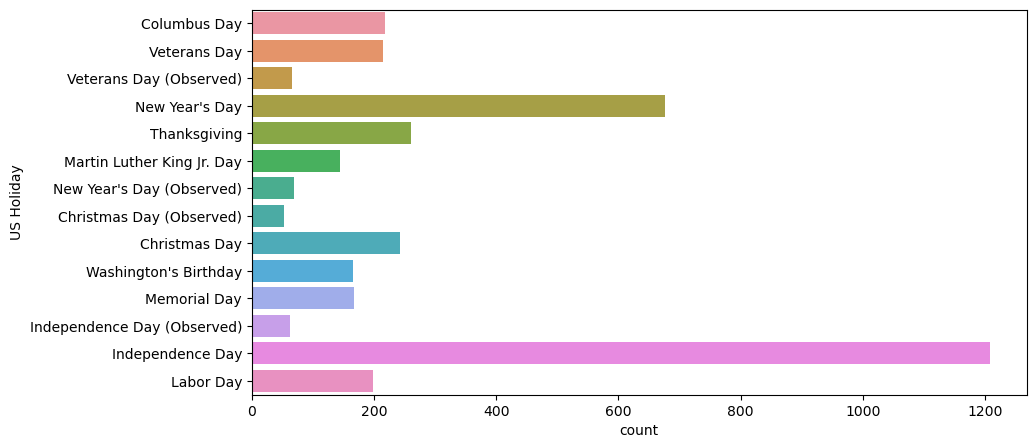

In [48]:
## Countplot of holidays
sns.countplot(data = eda_df, y = 'US Holiday');

#### Wait...when did that movie come out?

In [49]:
release_date= '1997-07-03'

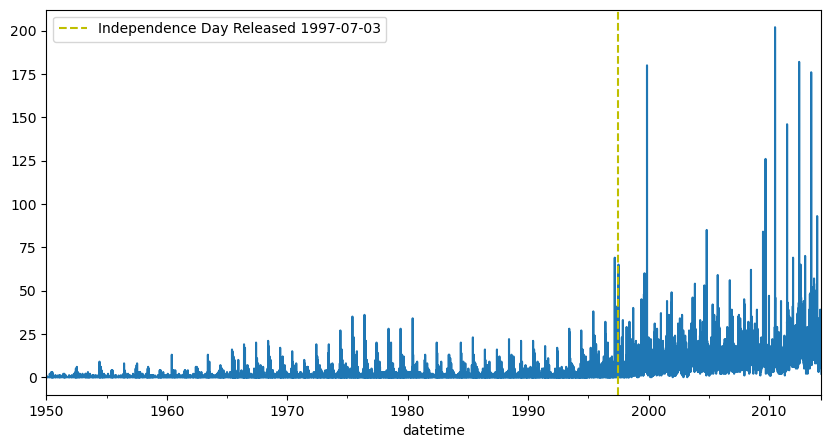

In [50]:
## Plot the # of sightings over time and annotate the release date
ax = ts.plot()
## Create vertical line at '1997-05-26'
ax.axvline(release_date, label = f'Independence Day Released {release_date}', ls = '--', color = 'y');

## Include a legend
ax.legend();

### 6) What day of the week has the highest reported sightings?

In [51]:
## create a column of day of the week names
eda_df['day_of_week'] = ufo_ts.index.day_name()
eda_df.head()

city state country     shape  \
datetime                                                            
1949-10-10 20:30:00            san marcos    tx      us  cylinder   
1949-10-10 21:00:00          lackland afb    tx     NaN     light   
1955-10-10 17:00:00  chester (uk/england)   NaN      gb    circle   
1956-10-10 21:00:00                  edna    tx      us    circle   
1960-10-10 20:00:00               kaneohe    hi      us     light   

                    duration (seconds) duration (hours/min)  \
datetime                                                      
1949-10-10 20:30:00               2700           45 minutes   
1949-10-10 21:00:00               7200              1-2 hrs   
1955-10-10 17:00:00                 20           20 seconds   
1956-10-10 21:00:00                 20             1/2 hour   
1960-10-10 20:00:00                900           15 minutes   

                                                              comments  \
datetime                                                                 
1949-10-10 20:30:00  This event took place in early fall around 194...   
1949-10-10 21:00:00  1949 Lackland AFB&#44 TX.  Lights racing acros...   
1955-10-10 17:00:00  Green/Orange circular disc over Chester&#44 En...   
1956-10-10 21:00:00  My older brother and twin sister were leaving ...   
1960-10-10 20:00:00  AS a Marine 1st Lt. flying an FJ4B fighter/att...   

                    date posted    latitude  longitude  US Holiday day_of_week  
datetime                                                                        
1949-10-10 20:30:00   4/27/2004  29.8830556  -97.941111       None      Monday  
1949-10-10 21:00:00  12/16/2005    29.38421  -98.581082       None      Monday  
1955-10-10 17:00:00   1/21/2008        53.2   -2.916667       None      Monday  
1956-10-10 21:00:00   1/17/2004  28.9783333  -96.645833       None   Wednesday  
1960-10-10 20:00:00   1/22/2004  21.4180556 -157.803611       None      Monday

In [52]:
## Save the value counts of days of the week
day_counts = eda_df['day_of_week'].value_counts()
## Create a list of the correct order of the days of the week
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
## Reorder the days of the week using .loc
day_counts = day_counts.loc[day_order]
day_counts

Monday       10064
Tuesday      10789
Wednesday    10980
Thursday     11030
Friday       11606
Saturday     14066
Sunday       11797
Name: day_of_week, dtype: int64

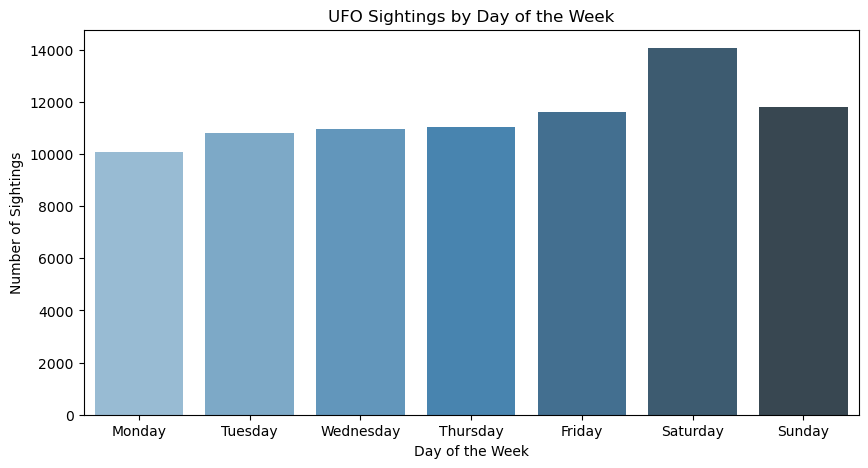

In [53]:
## Bar plot of sighting by week day
sns.barplot(x = day_counts.index, y = day_counts.values, palette = 'Blues_d')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Sightings')
plt.title('UFO Sightings by Day of the Week')
plt.show();

### 7) At what time of day (hour) do most sightings occur?

In [54]:
## Add an 'hour' column to the eda_df
eda_df['hour'] = eda_df.index.hour

In [66]:
## Get the value counts and sort the index (by hour)
hours = eda_df['hour'].value_counts().sort_index()
hours

0      4108
1      3210
2      2357
3      2004
4      1529
5      1591
6      1224
7       905
8       803
9       958
10     1166
11     1144
12     1368
13     1303
14     1322
15     1433
16     1620
17     2592
18     4002
19     6147
20     8617
21    11445
22    10837
23     8647
Name: hour, dtype: int64

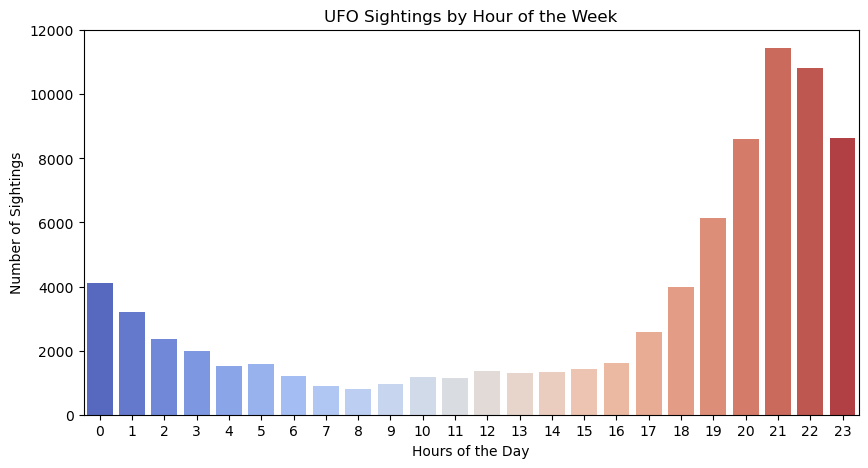

In [68]:
## Bar plot of hours of the day and sightings
sns.barplot(x = hours.index, y = hours.values, palette = 'coolwarm')
plt.xlabel('Hours of the Day')
plt.ylabel('Number of Sightings')
plt.title('UFO Sightings by Hour of the Week')
plt.show();

### 8) Which US state has the most sightings?

In [69]:
## Plot sightings by state
sightings_by_state = eda_df['state'].value_counts()

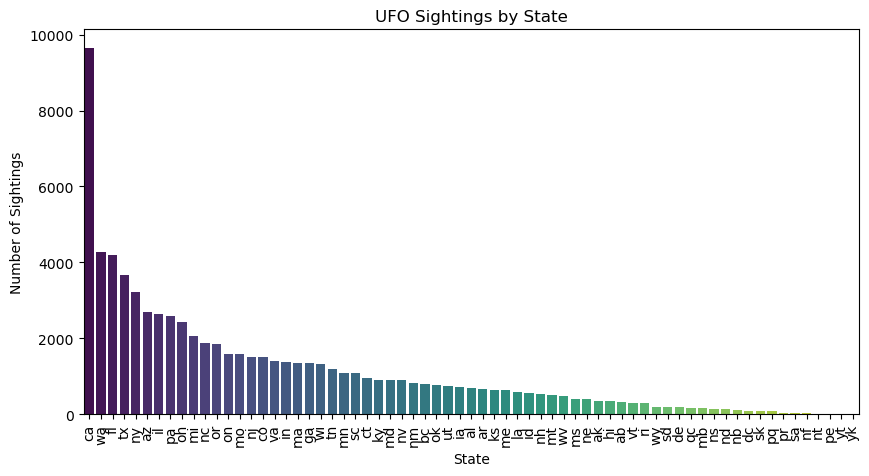

In [72]:
sns.barplot(x = sightings_by_state.index, y = sightings_by_state.values, palette = 'viridis')
plt.xlabel('State')
plt.ylabel('Number of Sightings')
plt.title('UFO Sightings by State')
plt.xticks(rotation = 90)
plt.show();

### 9) Which country had the largest proportion of sightings for the year 2000?

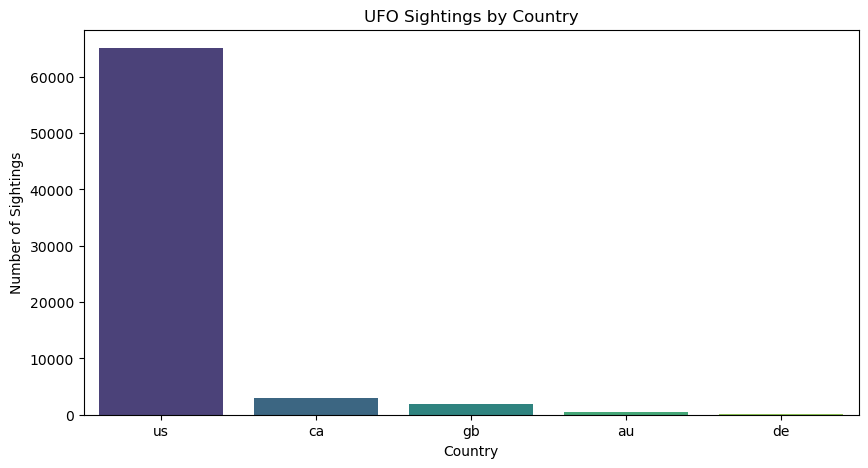

In [73]:
## Plot sightings by country
sightings_by_country = eda_df['country'].value_counts()

# plot
sns.barplot(x = sightings_by_country.index, y = sightings_by_country.values, palette = 'viridis')
plt.xlabel('Country')
plt.ylabel('Number of Sightings')
plt.title('UFO Sightings by Country')
# plt.xticks(rotation = 90)
plt.show();

# Bonus: Plotly Express

In [59]:
import plotly.express as px
import plotly.io as pio
pio.templates

Templates configuration
-----------------------
    Default template: 'plotly'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']

### Map Over Time

In [60]:
eda_df.columns

Index(['city', 'state', 'country', 'shape', 'duration (seconds)',
       'duration (hours/min)', 'comments', 'date posted', 'latitude',
       'longitude ', 'US Holiday', 'day_of_week', 'hour'],
      dtype='object')

In [61]:
eda_df['year'] = eda_df.index.year
eda_df['decade'] = eda_df['year'] - eda_df['year'] % 10
eda_df = eda_df.sort_values('decade')

In [62]:
# let's use coerce - 1 row is fine to lose
eda_df['latitude'] = pd.to_numeric(eda_df['latitude'], errors='coerce')
eda_df

city state country     shape  \
datetime                                                                     
1906-11-11 00:00:00                 wien (austria)   NaN     NaN     other   
1910-01-01 23:59:00              kirksville (near)    mo      us      disk   
1910-06-01 15:00:00                    wills point    tx      us     cigar   
1916-04-05 13:00:00  france (above; from aircraft)   NaN     NaN     cigar   
1929-07-05 14:00:00           buchanan  (or burns)    or      us      disk   
...                                            ...   ...     ...       ...   
2013-07-28 23:00:00                      englewood    fl      us  teardrop   
2013-07-28 22:40:00               langley (canada)    bc      ca  triangle   
2013-07-28 22:35:00                   cedar rapids    ia      us     light   
2011-02-07 16:32:00                         tacoma    wa      us    sphere   
2013-09-09 23:00:00                         edmond    ok      us     cigar   

                    duration (seconds) duration (hours/min)  \
datetime                                                      
1906-11-11 00:00:00              10800                  3 h   
1910-01-01 23:59:00                120              minutes   
1910-06-01 15:00:00                120            2 minutes   
1916-04-05 13:00:00                 60         about 1 min.   
1929-07-05 14:00:00                 60                 1min   
...                                ...                  ...   
2013-07-28 23:00:00                 60             1 minute   
2013-07-28 22:40:00                 20           20 seconds   
2013-07-28 22:35:00                 30           30 seconds   
2011-02-07 16:32:00                 60             1 minute   
2013-09-09 23:00:00               1020           17 minutes   

                                                              comments  \
datetime                                                                 
1906-11-11 00:00:00  The oldest professional photo of a UFO object ...   
1910-01-01 23:59:00  Historical sighting (1903 - 1913) Northern Mis...   
1910-06-01 15:00:00       Cigar shaped object moving from West to East   
1916-04-05 13:00:00  ((NUFORC Note:  Possible hoax.  PD))  Saw 3 ci...   
1929-07-05 14:00:00  we were traveling east of burns&#44clmbing up ...   
...                                                                ...   
2013-07-28 23:00:00              Low fying and flashing with no noise.   
2013-07-28 22:40:00  A triangular shaped craft appeared in the nigh...   
2013-07-28 22:35:00           Slow white glow across sky in 20 seconds   
2011-02-07 16:32:00  While looking out our east facing bathroom win...   
2013-09-09 23:00:00  2 witnesses 2  miles apart&#44 Red &amp; White...   

                    date posted   latitude  longitude       US Holiday  \
datetime                                                                 
1906-11-11 00:00:00  12/23/2002  48.208174   16.373819            None   
1910-01-01 23:59:00   9/15/2005  40.194722  -92.583056  New Year's Day   
1910-06-01 15:00:00   4/16/2005  32.709167  -96.008056            None   
1916-04-05 13:00:00    3/9/2004  46.227638    2.213749            None   
1929-07-05 14:00:00   8/16/2002  43.642500 -118.627500            None   
...                         ...        ...         ...             ...   
2013-07-28 23:00:00   8/30/2013  26.961667  -82.352778            None   
2013-07-28 22:40:00   8/30/2013  49.100000 -122.650000            None   
2013-07-28 22:35:00   8/30/2013  42.008333  -91.643889            None   
2011-02-07 16:32:00    2/8/2011  47.253056 -122.443056            None   
2013-09-09 23:00:00   9/30/2013  35.652778  -97.477778            None   

                    day_of_week  hour  year  decade  
datetime                                             
1906-11-11 00:00:00      Sunday     0  1906    1900  
1910-01-01 23:59:00    Saturday    23  1910    1910  
1910-06-01 15:00:00   Wednesday    15  1910    1910  
1916-04-05 13:0

In [63]:
try:
    px.scatter_geo(data_frame=eda_df, lat='latitude',lon='longitude', animation_frame="decade")
except Exception as e:
    display(e)

ValueError("Value of 'lon' is not the name of a column in 'data_frame'. Expected one of ['city', 'state', 'country', 'shape', 'duration (seconds)', 'duration (hours/min)', 'comments', 'date posted', 'latitude', 'longitude ', 'US Holiday', 'day_of_week', 'hour', 'year', 'decade'] but received: longitude")

In [64]:
eda_df.columns = eda_df.columns.str.strip()
eda_df

city state country     shape  \
datetime                                                                     
1906-11-11 00:00:00                 wien (austria)   NaN     NaN     other   
1910-01-01 23:59:00              kirksville (near)    mo      us      disk   
1910-06-01 15:00:00                    wills point    tx      us     cigar   
1916-04-05 13:00:00  france (above; from aircraft)   NaN     NaN     cigar   
1929-07-05 14:00:00           buchanan  (or burns)    or      us      disk   
...                                            ...   ...     ...       ...   
2013-07-28 23:00:00                      englewood    fl      us  teardrop   
2013-07-28 22:40:00               langley (canada)    bc      ca  triangle   
2013-07-28 22:35:00                   cedar rapids    ia      us     light   
2011-02-07 16:32:00                         tacoma    wa      us    sphere   
2013-09-09 23:00:00                         edmond    ok      us     cigar   

                    duration (seconds) duration (hours/min)  \
datetime                                                      
1906-11-11 00:00:00              10800                  3 h   
1910-01-01 23:59:00                120              minutes   
1910-06-01 15:00:00                120            2 minutes   
1916-04-05 13:00:00                 60         about 1 min.   
1929-07-05 14:00:00                 60                 1min   
...                                ...                  ...   
2013-07-28 23:00:00                 60             1 minute   
2013-07-28 22:40:00                 20           20 seconds   
2013-07-28 22:35:00                 30           30 seconds   
2011-02-07 16:32:00                 60             1 minute   
2013-09-09 23:00:00               1020           17 minutes   

                                                              comments  \
datetime                                                                 
1906-11-11 00:00:00  The oldest professional photo of a UFO object ...   
1910-01-01 23:59:00  Historical sighting (1903 - 1913) Northern Mis...   
1910-06-01 15:00:00       Cigar shaped object moving from West to East   
1916-04-05 13:00:00  ((NUFORC Note:  Possible hoax.  PD))  Saw 3 ci...   
1929-07-05 14:00:00  we were traveling east of burns&#44clmbing up ...   
...                                                                ...   
2013-07-28 23:00:00              Low fying and flashing with no noise.   
2013-07-28 22:40:00  A triangular shaped craft appeared in the nigh...   
2013-07-28 22:35:00           Slow white glow across sky in 20 seconds   
2011-02-07 16:32:00  While looking out our east facing bathroom win...   
2013-09-09 23:00:00  2 witnesses 2  miles apart&#44 Red &amp; White...   

                    date posted   latitude   longitude      US Holiday  \
datetime                                                                 
1906-11-11 00:00:00  12/23/2002  48.208174   16.373819            None   
1910-01-01 23:59:00   9/15/2005  40.194722  -92.583056  New Year's Day   
1910-06-01 15:00:00   4/16/2005  32.709167  -96.008056            None   
1916-04-05 13:00:00    3/9/2004  46.227638    2.213749            None   
1929-07-05 14:00:00   8/16/2002  43.642500 -118.627500            None   
...                         ...        ...         ...             ...   
2013-07-28 23:00:00   8/30/2013  26.961667  -82.352778            None   
2013-07-28 22:40:00   8/30/2013  49.100000 -122.650000            None   
2013-07-28 22:35:00   8/30/2013  42.008333  -91.643889            None   
2011-02-07 16:32:00    2/8/2011  47.253056 -122.443056            None   
2013-09-09 23:00:00   9/30/2013  35.652778  -97.477778            None   

                    day_of_week  hour  year  decade  
datetime                                             
1906-11-11 00:00:00      Sunday     0  1906    1900  
1910-01-01 23:59:00    Saturday    23  1910    1910  
1910-06-01 15:00:00   Wednesday    15  1910    1910  
1916-04-05 13:0

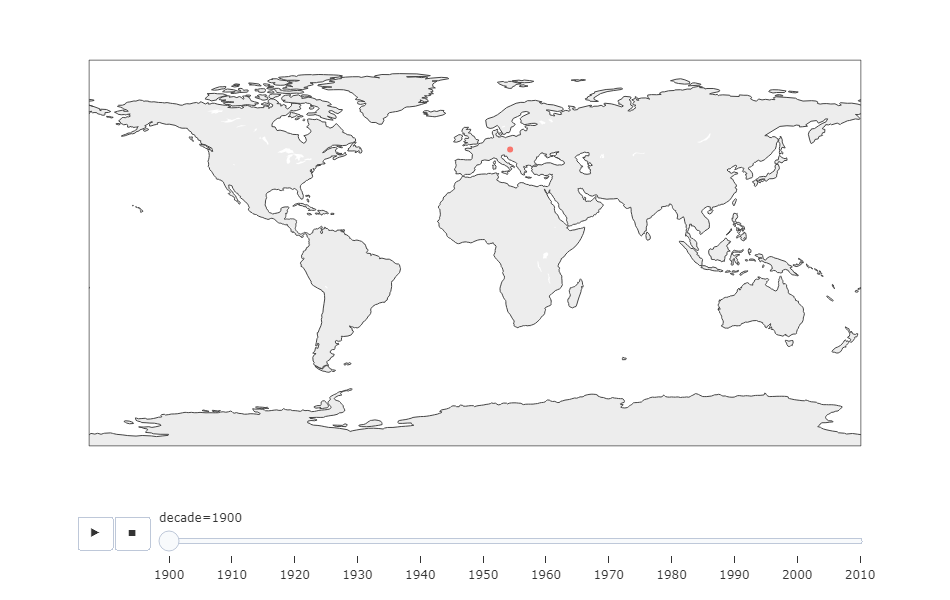

In [77]:
import plotly.express as px
fig = px.scatter_geo(data_frame=eda_df, lat='latitude',lon='longitude', animation_frame="decade",
              template='ggplot2')
# enlarge map
fig.update_layout(width = 800, height = 600)
fig.show()